## 셸로우 포커스 만들기 (1) 사진을 준비하자

In [1]:
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

In [47]:
import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/F_my_image3.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(1440, 1080, 3)


## 셸로우 포커스 만들기 (2) 세그멘테이션으로 사람 분리하기

### 세그멘테이션(Segmentation)이 뭔가요?

- 이미지에서 픽셀 단위로 관심 객체를 추출하는 방법을 이미지 세그멘테이션(image segmentation) 이라고 합니다. 이미지 세그멘테이션은 모든 픽셀에 라벨(label)을 할당하고 같은 라벨은 "공통적인 특징"을 가진다고 가정합니다. 이 때 공통 특징은 물리적 의미가 없을 수도 있습니다. 픽셀이 비슷하게 생겼다는 사실은 인식하지만, 우리가 아는 것처럼 실제 물체 단위로 인식하지 않을 수 있는 것이죠. 물론 세그멘테이션에는 여러 가지 세부 태스크가 있으며, 태스크에 따라 다양한 기준으로 객체를 추출합니다.

### 시멘틱 세그멘테이션(semantic segmentation)이란?
- 세그멘테이션 중에서도 특히 우리가 인식하는 세계처럼 물리적 의미 단위로 인식하는 세그멘테이션을 시맨틱 세그멘테이션 이라고 합니다. 쉽게 설명하면 이미지에서 픽셀을 사람, 자동차, 비행기 등의 물리적 단위로 분류(classification)하는 방법이라고 이해하시면 됩니다. 오늘 다룰 세그멘테이션 방법이기도 하죠.

### 인스턴스 세그멘테이션(Instance segmentation)이란?
- 시맨틱 세그멘테이션은 '사람'이라는 추상적인 정보를 이미지에서 추출해내는 방법입니다. 그래서 사람이 누구인지 관계없이 같은 라벨로 표현이 됩니다. 더 나아가서 인스턴스 세그멘테이션은 사람 개개인 별로 다른 라벨을 가지게 합니다. 여러 사람이 한 이미지에 등장할 때 각 객체를 분할해서 인식하자는 것이 목표입니다.

### 이미지 세그멘테이션의 간단한 알고리즘 : 워터쉐드 세그멘테이션(watershed segmentation)
- 이미지에서 영역을 분할하는 가장 간단한 방법은 물체의 '경계'를 나누는 것입니다. 그럼 경계는 어떻게 나눌 수 있을까요? 이미지는 그레이스케일(grayscale)로 변환하면 0~255의 값을 가집니다. 픽셀 값을 이용해서 각 위치의 높고 낮음을 구분할 수 있는데요. 낮은 부분부터 서서히 '물'을 채워 나간다고 생각할 때 각 영역에서 점점 물이 차오르다가 넘치는 시점이 생기게 됩니다. 그 부분을 경계선으로 만들면 물체를 서로 구분할 수 있게 됩니다.

## 셸로우 포커스 만들기 (3) 시맨틱 세그멘테이션 다뤄보기

- 본격적으로 세그멘테이션을 구현해 보겠습니다. 세그멘테이션 문제에는 FCN, SegNet, U-Net 등 많은 모델이 사용됩니다. 오늘은 그 중에서 DeepLab이라는 세그멘테이션 모델을 만들고 모델에 이미지를 입력하겠습니다. DeepLab 알고리즘(DeepLab v3+)은 세그멘테이션 모델 중에서도 성능이 매우 좋아 최근까지도 많이 사용되고 있습니다.

In [48]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
            tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [49]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = '~/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: ~/aiffel/human_segmentation/models
model loaded successfully!


In [50]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(1440, 1080, 3) (513, 384, 3) 15


In [51]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

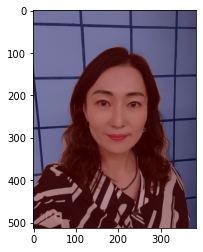

In [52]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

## 셸로우 포커스 만들기 (4) 세그멘테이션 결과를 원래 크기로 복원하기

- DeepLab 모델을 사용하기 위해 이미지 크기를 작게 resize 해서 입력했습니다. 따라서 출력도 resize 된 입력 크기와 같게 나오게 됩니다. 세그멘테이션 결과(mask)를 원래 크기로 복원해 보겠습니다.

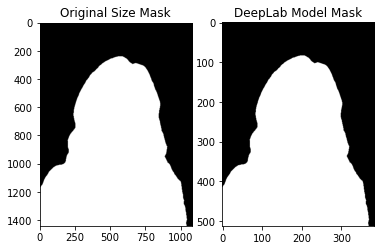

In [53]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

## 셸로우 포커스 만들기 (5) 배경 흐리게 하기

- 이번에는 배경을 흐리게 하기 위해서 세그멘테이션 마스크를 이용해서 배경만 추출하겠습니다.

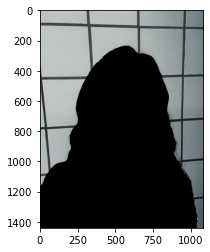

In [54]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
plt.imshow(img_bg)
plt.show()

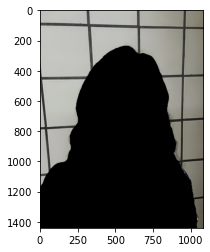

In [55]:
# 이 이미지를 블러(blur)하면 배경이 흐리게 처리된 영상을 얻을 수 있습니다.

img_bg_blur = cv2.blur(img_bg, (1,1))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

## 셸로우 포커스 만들기 (6) 흐린 배경과 원본 영상 합성

- 이제 배경 영상과 사람 영상을 합치기만 하면 되겠죠?
- 세그멘테이션 마스크가 255인 부분만 원본 영상을 가지고 오고 반대인 영역은 블러된 미지 값을 사용합니다.

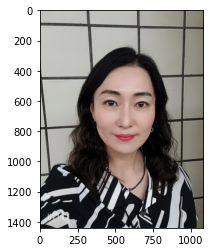

In [56]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 프로젝트: 인물 모드 문제점 찾기

### Step 1. 인물모드 직접 해 보기

- 여러분의 셀카를 이용해서 오늘 배운 내용을 수행해 봅시다. 아래와 같은 이미지를 얻어야 합니다. 최소 3장 이상의 인물모드 사진을 만들어 봅시다.
- 인물이 주인공이 아닌, 귀여운 고양이에 대한 아웃포커싱 사진도 만들어 볼 수 있을 것입니다. 시맨틱 세그멘테이션 스텝에서 힌트를 찾아봅시다.
- 배경을 blur하는 인물모드 사진이 아니라 배경사진을 다른 이미지로 교체하는 크로마키 배경합성을 시도해 볼 수도 있을 것입니다. 여러분만의 환상적인 사진을 만들어 보면 어떨까요?


In [69]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/1594429715635.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(1440, 1080, 3)


In [80]:
img_paths = glob('images/F_*.jpg')  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_paths.sort()
img_paths

['images/F_background.jpg',
 'images/F_background1.jpg',
 'images/F_diningtable1.jpg',
 'images/F_diningtable2.jpg',
 'images/F_diningtable3.jpg',
 'images/F_my_image1.jpg',
 'images/F_my_image2.jpg',
 'images/F_my_image3.jpg']

In [81]:
img_origs = []

for path in img_paths : 
    img_origs.append(cv2.imread(path))

img_origs[0].shape

(1534, 950, 3)

In [86]:
def segmentation(img_orig, label):
    img_resized, seg_map = MODEL.run(img_orig)
    LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv']
    
    label_idx = LABEL_NAMES.index(label)
    
    img_show = img_resized.copy()
    seg_map = np.where(seg_map == label_idx, label_idx, 0) # 예측 중 사람만 추출
    img_mask = seg_map * (255/seg_map.max()) # 255 normalization
    img_mask = img_mask.astype(np.uint8)
    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
    img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)
    
    plt.figure(figsize=(15, 30))
    plt.subplot(1,2,1)
    plt.title('segmentation img')
    plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
#     plt.show()
    

    img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
    _, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

    img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
    
    img_bg_blur = cv2.blur(img_bg, (400, 400))  # 원래는 (13, 13),값을 엄청 올려서 효과를 높여 봤다.
    
    img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
    
    plt.subplot(1,2,2)
    plt.title('blurred img')
    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    plt.show()

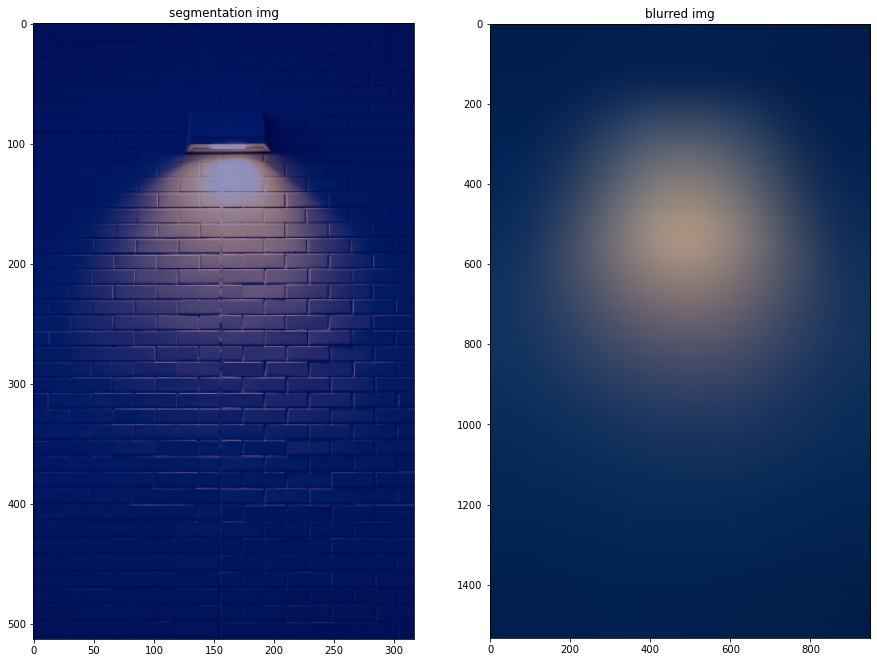

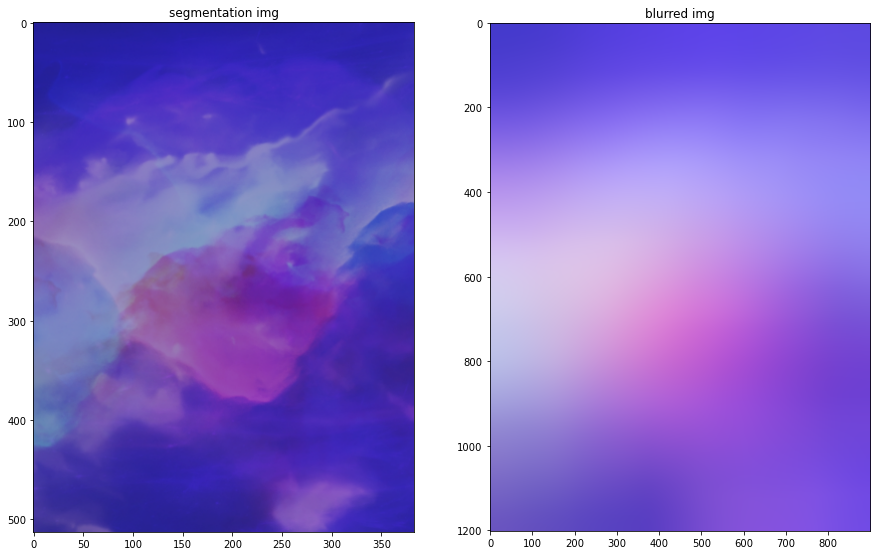

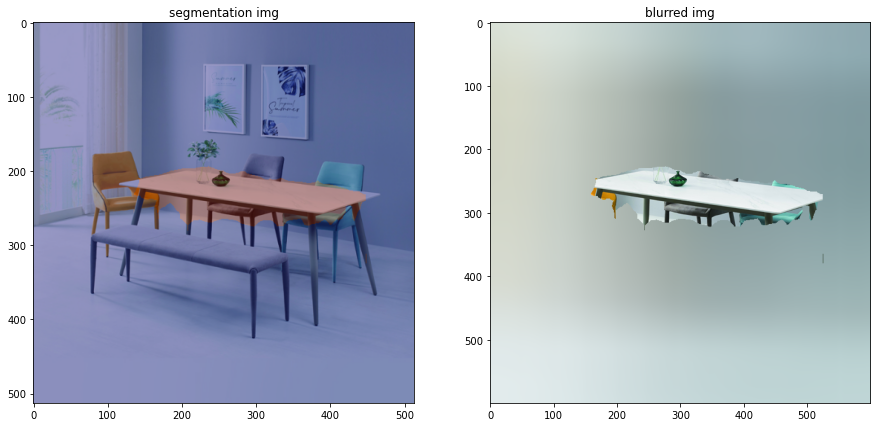

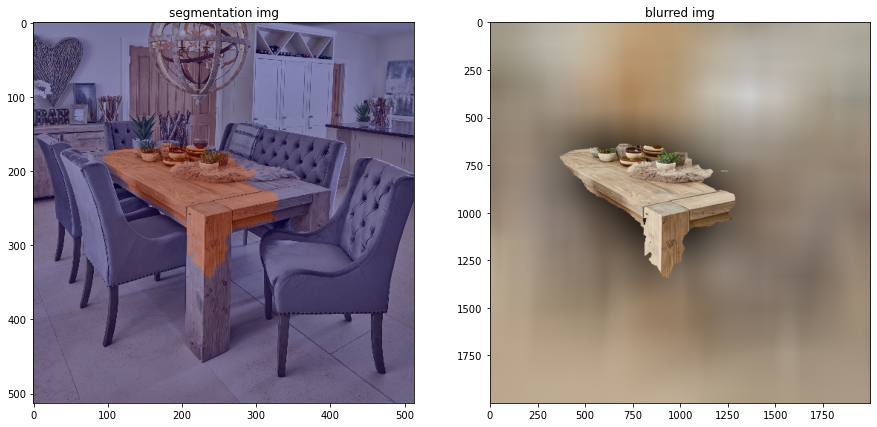

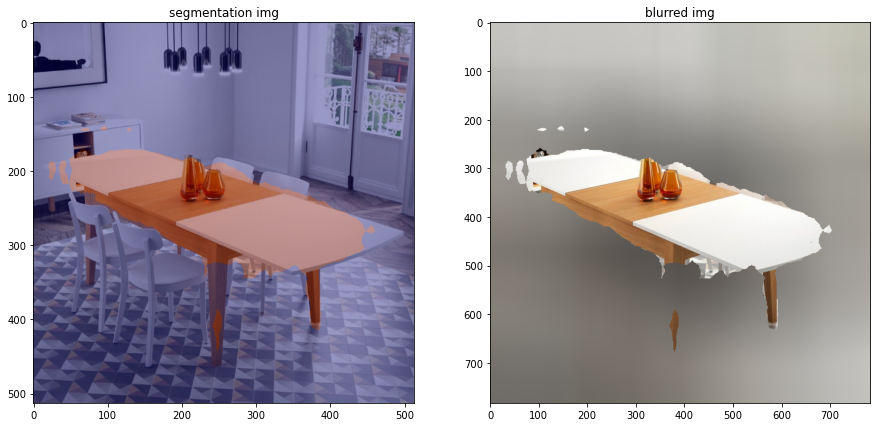

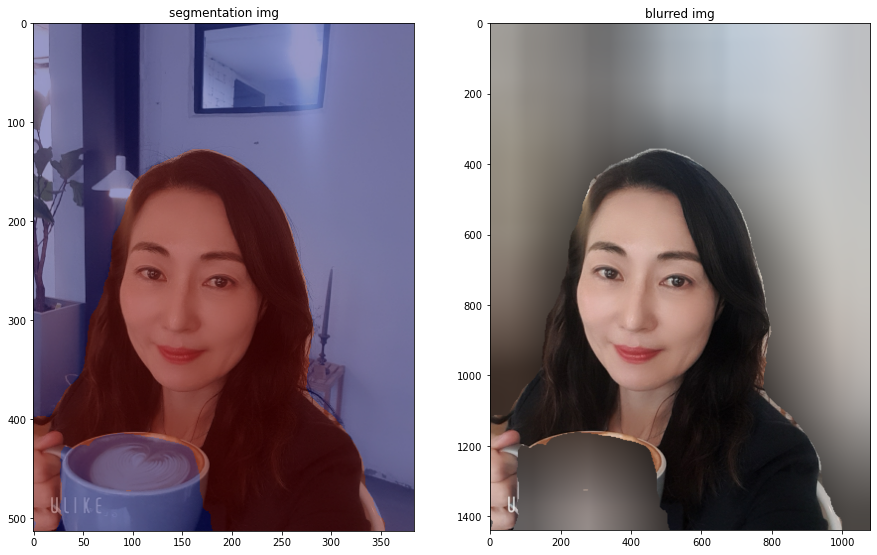

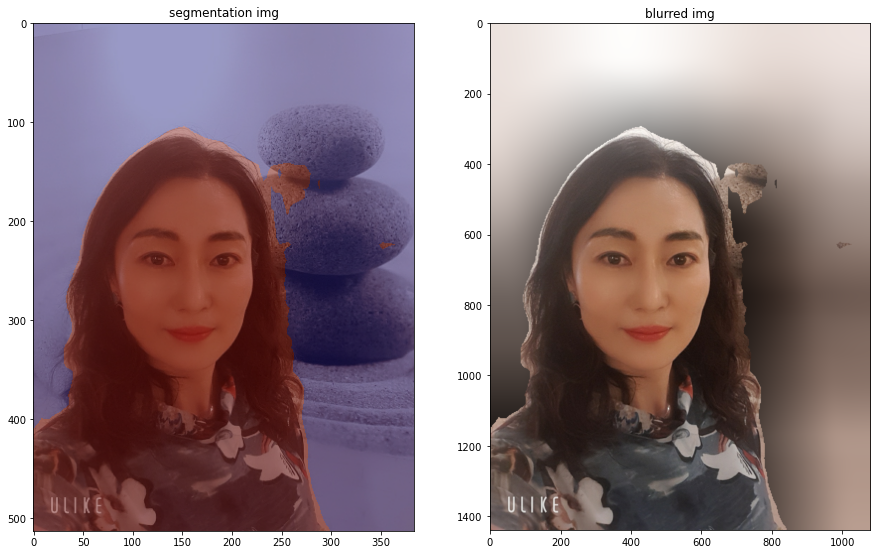

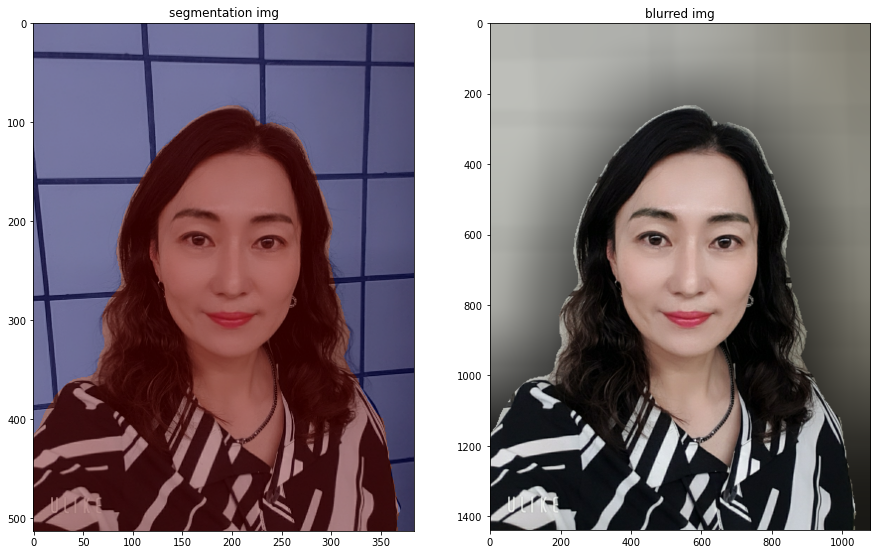

In [87]:
import warnings
warnings.filterwarnings("ignore")

lst = ['background', 'background', 'diningtable', 'diningtable', 'diningtable', 'person', 'person', 'person']
for i in range(len(img_origs)) :
    segmentation(img_origs[i], lst[i])

### 배경 바꿔보기

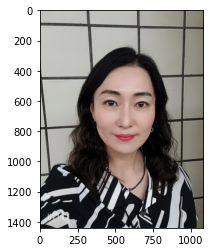

(1440, 1080, 3)


In [74]:
cute_ = cv2.cvtColor(cv2.imread('images/F_my_image3.jpg'), cv2.COLOR_BGR2RGB)
cute = cv2.imread('images/F_my_image3.jpg')
plt.imshow(cute_)
plt.show()
h, w, _ = cute.shape
print(cute.shape)

In [75]:
def ret_mask(img_path) :
    # 이미지 읽기
    img_gbr = cv2.imread(img_path)
    img_resized, seg_map = MODEL.run(img_gbr)
    
    img_show = img_resized.copy()
    seg_map = np.where(seg_map == seg_map.max(), seg_map.max(), 0)
    img_mask = seg_map * (255/seg_map.max())
    img_mask = img_mask.astype(np.uint8)
    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
#     img_show = cv2.addWeighted(img_show, 0.6)
    
    img_mask_up = cv2.resize(img_mask, img_gbr.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
    _, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)
    
    img_content_mask = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
    
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    
    content = cv2.cvtColor(cv2.bitwise_and(cute, img_mask_color), cv2.COLOR_BGR2RGB)
    
    
    
    return img_bg_mask, img_mask_color, content

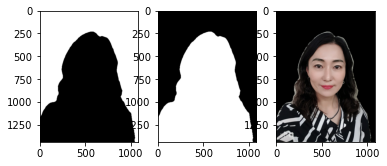

In [76]:
cute_bg_mask, cute_content_mask, cute_content = ret_mask('images/F_my_image3.jpg')
plt.subplot(1,3,1)
plt.imshow(cute_bg_mask)
plt.subplot(1,3,2)
plt.imshow(cute_content_mask)
plt.subplot(1,3,3)
plt.imshow(cute_content)
plt.show()

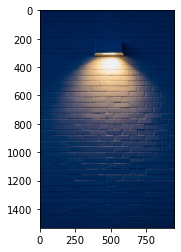

(1534, 950, 3)


In [65]:
back1 = cv2.cvtColor(cv2.imread('images/F_background.jpg'), cv2.COLOR_BGR2RGB)
plt.imshow(back1)
plt.show()
print(back1.shape)

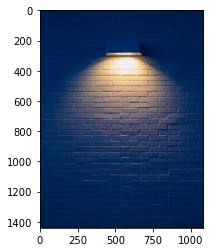

In [66]:
back1 = cv2.resize(back1, (w, h))
plt.imshow(back1)
plt.show()

In [67]:
np.unique(cute_content_mask)

array([  0, 255], dtype=uint8)

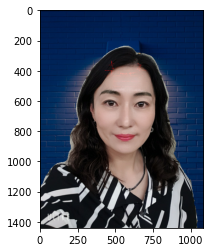

In [68]:
result1 = cv2.bitwise_and(back1, cute_content_mask)
result1 = np.where(result1 == cute_content_mask, back1, cute_content)
plt.imshow(result1)
plt.show()

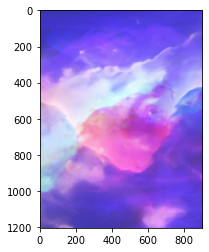

(1203, 900, 3)


In [77]:
back1 = cv2.cvtColor(cv2.imread('images/F_background1.jpg'), cv2.COLOR_BGR2RGB)
plt.imshow(back1)
plt.show()
print(back1.shape)

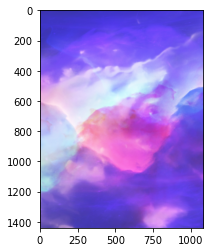

In [78]:
back1 = cv2.resize(back1, (w, h))
plt.imshow(back1)
plt.show()

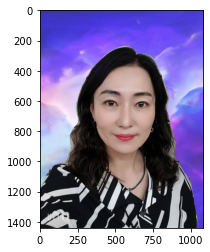

In [79]:
result1 = cv2.bitwise_and(back1, cute_content_mask)
result1 = np.where(result1 == cute_content_mask, back1, cute_content)
plt.imshow(result1)
plt.show()

### Step 2. 사진에서 문제점 찾기

- 그러나 여러분들의 사진에는 무언가 문제점이 있을 것입니다.
- 아래 사진에도 문제점이 몇가지 있었습니다. 예를 들어 뒤에 걸린 옷이 인물 영역에 포함되어 blur돠지 않고 나온다던가 하는 경우입니다. ㅠㅠ 그 외 다른 문제들이 눈에 띄시나요? 아래 사진에는 이상한 점이 최소 2개 이상 더 있습니다. 어떤 문제가 있는지 찾아서 아래 사진처럼 표시해 봅시다.
- 추가로 여러분이 만들어 낸 인물 모드 사진 중 하나에서도 이상한 위치를 찾아 아래 사진처럼 표시해 봅시다. 표시한 이미지들을 jupyter notebook에 포함하여 제출해 주세요.

![title](images/result.png)

### Step 3. 해결 방법을 제안해 보기

- 아주 간단히 멋진 카메라앱 서비스를 만들어 출시할 수 있을 것 같았지만, 지금같은 완성도로는 어림도 없습니다. 소비자들의 눈높이는 그리 호락호락하지 않고, 엔지니어인 여러분들은 답을 찾아내야 합니다.
- 생각해 볼만한 주제를 아래에 몇가지 제시해 봅니다. 아래를 읽어본 후, 여러분이 만든 인물모드 사진의 문제점을 해결할 방안을 정리하여 제안해 주시기 바랍니다.
- 단순히 'XXX 기술을 사용한다.' 정도의 선언적 솔루션이 아니라, 여러분들이 선택한 기술이 DeepLab 모델의 Semantic Segmentation 이 만들어 낸 Mask 영역에 어떻게 적용되어 문제점을 보완하게 되는지의 메커니즘이 포함된 솔루션이어야 합니다.

(1) 세그멘테이션의 한계
- Semantic segmentation의 부정확성이 여러가지 문제를 발생시키는 주요 원인입니다. 피사계심도를 이용한 보케(아웃포커싱) 효과는 말 그대로 심도를 표현하기 때문에 초점이 잡힌 거리를 광학적으로 아주 섬세하게 구별(segmentation) 하지만 이를 따라한 semantic segmentation 모듈은 정확도가 1.00 이 되지 않는 한 완벽히 구현하기는 힘듭니다.

(2) 피사계 심도 이해하기
- 우선 피사계심도의 개념부터 명확히 이해해 봅시다. 
- 참고자료 : https://ggyul.tistory.com/12

(3) 3D Depth Camera 활용하기
- 카메라 2개를 통해 생성한 3d 영상으로 인물모드를 더 정확하게 만들 수 있을까요? 우리는 카메라 1대가 찍은 영상에서 semantic segmentation을 시도하였고, 그 결과가 정확하지 않았습니다. 요즘 스마트폰의 카메라는 렌즈가 2개 달려있지요? 왜 굳이 그렇게까지 하는지 아래 링크를 보면서 이해해 봅시다. 
- 참고자료 : https://m.blog.naver.com/panoptics/221336152952

(4) 깊이 영상(Depth image) 활용하기
- 하지만 꼭 카메라가 2개여야 할까요? 아래 이미지는 Struct2Depth 라는 기법을 소개한 Google Brain의 논문에 있는 이미지입니다. 세번째 컬럼이 보다 명확하게 depth에 따른 물체인식을 보여 주는데, 이것은 LiDAR가 없이도 아주 정확한 segmentation을 동반한 depth sensor가 가능함을 보여줍니다.
- 참고자료 : https://towardsdatascience.com/depth-prediction-autonomous-driving-18d05ff25dd6
- 참고자료 : https://sites.google.com/view/struct2depth



### 이 부분은 넘 어려워서 다음에 해보겠습니다!